## Cross Validation

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

sns.set_theme(style="whitegrid")
print(f"PyTorch Version: {torch.__version__}")
print(f"Scikit-learn Version: {sklearn.__version__}")

torch.manual_seed(42)
np.random.seed(42)

PyTorch Version: 2.3.0+cu118
Scikit-learn Version: 1.2.2


**Why Cross-Validation?** 

- A single train-test split can be sensitive to how the data is divided. The model's performance on one particular test set might not be representative of its true generalization ability.
- It's especially useful when the dataset is relatively small.
- Essential for reliable hyperparameter tuning.

In [3]:
# Generating synthetic classification data
# Binary classification dataset
N_SAMPLES_CV = 200
X_np_cv, y_np_cv = make_classification(
    n_samples=N_SAMPLES_CV, n_features=5, n_informative=3, n_redundant=0, 
    n_clusters_per_class=1, random_state=42, flip_y=0.05
    )

In [4]:
X_np_cv[:5], y_np_cv[:5]

(array([[ 0.43478795, -0.6089839 , -0.03534122,  1.06667469,  1.16929559],
        [-1.83777452,  3.30594194, -2.87889884,  1.02915564,  0.47259748],
        [ 2.23722377,  1.21369884, -2.95900625,  0.13296967, -0.70012081],
        [-1.41841169,  2.21444838, -2.11305737,  0.38019785,  0.61058575],
        [ 1.91074961,  0.85573189,  0.49234303, -0.63773998, -0.53099696]]),
 array([1, 0, 1, 0, 1]))

In [5]:
scaler_cv = StandardScaler()
X_scaled_np_cv = scaler_cv.fit_transform(X_np_cv)

In [6]:
X_scaled_np_cv[:5]

array([[ 0.36990267, -1.69249026,  0.98843979,  1.06424121,  1.06525641],
       [-1.28804794,  2.2731233 , -2.00764006,  1.02484315,  0.37065181],
       [ 1.68487183,  0.15379131, -2.09204426,  0.08377491, -0.7985426 ],
       [-0.9821013 ,  1.16749785, -1.20072053,  0.34338463,  0.50822543],
       [ 1.44669222, -0.20881035,  1.54442787, -0.72553299, -0.62992694]])

In [7]:
X_cv = torch.from_numpy(X_scaled_np_cv).float()
y_cv = torch.from_numpy(y_np_cv).float().unsqueeze(1)

In [8]:
X_cv.shape, y_cv.shape

(torch.Size([200, 5]), torch.Size([200, 1]))

In [9]:
class LogisticRegressionPyTorch(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionPyTorch, self).__init__()
        self.linear = nn.Linear(input_dim, 1) 

    def forward(self, x):
        return self.linear(x) # Return logits

In [10]:
def train_pytorch_model(model_instance, X_train_fold, y_train_fold,
                        criterion, optimizer, num_epochs=100, verbose=False):
    """Helper function to train a PyTorch model for one fold."""
    model_instance.train() 
    epoch_losses = []
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model_instance(X_train_fold) 
        
        # Compute loss
        loss = criterion(outputs, y_train_fold) # Criterion expects logits if BCEWithLogitsLoss
        epoch_losses.append(loss.item())

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if verbose and (epoch + 1) % (num_epochs // 2) == 0 :
             print(f"    Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    return epoch_losses

In [11]:
def evaluate_pytorch_model(model_instance, X_val_fold, y_val_fold, threshold=0.5):
    """Helper function to evaluate a PyTorch binary classification model."""
    model_instance.eval() # Set model to evaluation mode
    with torch.no_grad():
        logits = model_instance(X_val_fold)
        probabilities = torch.sigmoid(logits) # Convert logits to probabilities
        predictions = (probabilities >= threshold).float()
    
    accuracy = accuracy_score(y_val_fold.cpu().numpy(), predictions.cpu().numpy())
    return accuracy

### K-Fold Cross-Validation

The dataset is divided into K equally (for neraly equally) sized "folds". The model is trained K times:

- In each iteration, K-1 folds are used for training, and 1 fold is used for validation.
- Performance metrics are collected from each validation fold.
- The overall performance is typically the average of the metrics across all K folds.

In [12]:
N_SPLITS_KFold = 5 
kfold = KFold(n_splits=N_SPLITS_KFold, shuffle=True, random_state=42)

In [28]:
fold_accuracies_kfold = []
current_fold = 0
for fold_idx, (train_indices, val_indices) in enumerate(kfold.split(X_cv, y_cv)):
    current_fold += 1
    print(f"\n--- Fold {current_fold}/{N_SPLITS_KFold} ---")

    # Get training and validation data for this fold
    X_train_fold, y_train_fold = X_cv[train_indices], y_cv[train_indices]
    X_val_fold, y_val_fold = X_cv[val_indices], y_cv[val_indices]
    
    print(f"  Train samples: {X_train_fold.shape[0]}, Validation samples: {X_val_fold.shape[0]}")

    # Initialize model,
    input_dim_cv = X_cv.shape[1]
    model_kfold = LogisticRegressionPyTorch(input_dim_cv)
    
    # Use BCEWithLogitsLoss for numerical stability (expects raw logits from model)
    criterion_kfold = nn.BCEWithLogitsLoss() 
    optimizer_kfold = optim.SGD(model_kfold.parameters(), lr=0.05)
    
    # Train the model
    print(f"  Training model for Fold {current_fold}...")
    train_pytorch_model(model_kfold, X_train_fold, y_train_fold,
                        criterion_kfold, optimizer_kfold, num_epochs=150, verbose=False) # Less verbose in loop
    
    # Evaluate
    val_accuracy = evaluate_pytorch_model(model_kfold, X_val_fold, y_val_fold)
    fold_accuracies_kfold.append(val_accuracy)
    print(f"  Fold {current_fold} Validation Accuracy: {val_accuracy:.4f}")



--- Fold 1/5 ---
  Train samples: 160, Validation samples: 40
  Training model for Fold 1...
  Fold 1 Validation Accuracy: 0.7500

--- Fold 2/5 ---
  Train samples: 160, Validation samples: 40
  Training model for Fold 2...
  Fold 2 Validation Accuracy: 0.6500

--- Fold 3/5 ---
  Train samples: 160, Validation samples: 40
  Training model for Fold 3...
  Fold 3 Validation Accuracy: 0.9500

--- Fold 4/5 ---
  Train samples: 160, Validation samples: 40
  Training model for Fold 4...
  Fold 4 Validation Accuracy: 0.9250

--- Fold 5/5 ---
  Train samples: 160, Validation samples: 40
  Training model for Fold 5...
  Fold 5 Validation Accuracy: 0.9000


In [29]:
mean_accuracy_kfold = np.mean(fold_accuracies_kfold)
std_accuracy_kfold = np.std(fold_accuracies_kfold)

In [30]:
print("\n--- K-Fold CV Results ---")
print(f"Individual Fold Accuracies: {[f'{acc:.4f}' for acc in fold_accuracies_kfold]}")
print(f"Mean Validation Accuracy: {mean_accuracy_kfold:.4f}")
print(f"Standard Deviation of Validation Accuracy: {std_accuracy_kfold:.4f}")


--- K-Fold CV Results ---
Individual Fold Accuracies: ['0.7500', '0.6500', '0.9500', '0.9250', '0.9000']
Mean Validation Accuracy: 0.8350
Standard Deviation of Validation Accuracy: 0.1158


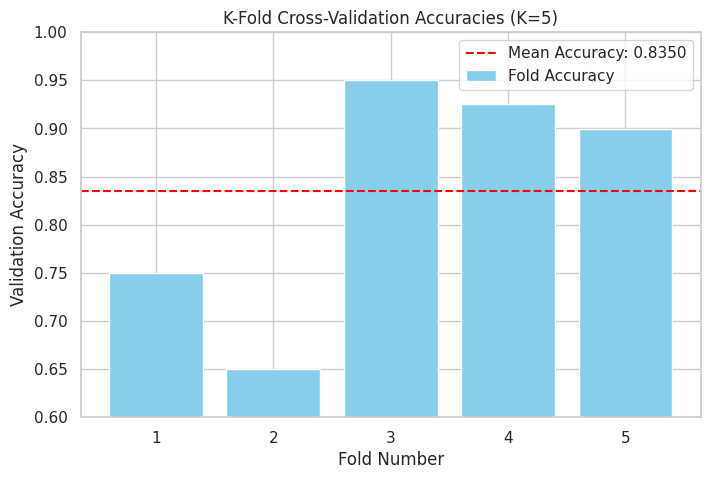

In [31]:
plt.figure(figsize=(8, 5))
plt.bar(range(1, N_SPLITS_KFold + 1), fold_accuracies_kfold, color='skyblue', label='Fold Accuracy')
plt.axhline(mean_accuracy_kfold, color='red', linestyle='--', label=f'Mean Accuracy: {mean_accuracy_kfold:.4f}')
plt.xlabel("Fold Number")
plt.ylabel("Validation Accuracy")
plt.title(f"K-Fold Cross-Validation Accuracies (K={N_SPLITS_KFold})")
plt.xticks(range(1, N_SPLITS_KFold + 1))
plt.ylim(min(fold_accuracies_kfold) - 0.05, max(fold_accuracies_kfold) + 0.05)
plt.legend()
plt.show()

### Stratified K-Fold Cross-Validation

- **Problem with KFold:** If classes are imbalanced, some folds might end up with very few or even zero samples of a particular class, leading to unreliable evaluation.
- **Stratified K-Fold:** Variation of K-Fold that returns stratified folds. Each fold is made by preserving the percentage of samples for each class as in the original dataset. Particularly, imporant for classification tasks with imbalanced class distributions.

In [32]:
N_SPLITS_STRATIFIED = 5
stratified_kfold = StratifiedKFold(n_splits=N_SPLITS_STRATIFIED, shuffle=True, random_state=42)

In [33]:
fold_accuracies_stratified = []
current_fold_strat = 0
for fold_idx, (train_indices, val_indices) in enumerate(stratified_kfold.split(X_cv, y_cv.squeeze())):
    current_fold_strat += 1
    print(f"\n--- Stratified Fold {current_fold_strat}/{N_SPLITS_STRATIFIED} ---")

    X_train_fold_s, y_train_fold_s = X_cv[train_indices], y_cv[train_indices]
    X_val_fold_s, y_val_fold_s = X_cv[val_indices], y_cv[val_indices]
    
    print(f"  Train samples: {X_train_fold_s.shape[0]}, Validation samples: {X_val_fold_s.shape[0]}")
    print(f"  Train class balance: Class 0: {(y_train_fold_s==0).sum().item()}, Class 1: {(y_train_fold_s==1).sum().item()}")
    print(f"  Val class balance:   Class 0: {(y_val_fold_s==0).sum().item()}, Class 1: {(y_val_fold_s==1).sum().item()}")


    input_dim_cv_s = X_cv.shape[1]
    model_stratified_kfold = LogisticRegressionPyTorch(input_dim_cv_s)
    criterion_stratified_kfold = nn.BCEWithLogitsLoss()
    optimizer_stratified_kfold = optim.SGD(model_stratified_kfold.parameters(), lr=0.05)
    
    print(f"  Training model for Stratified Fold {current_fold_strat}...")
    train_pytorch_model(model_stratified_kfold, X_train_fold_s, y_train_fold_s,
                        criterion_stratified_kfold, optimizer_stratified_kfold, num_epochs=150, verbose=False)
    
    val_accuracy_s = evaluate_pytorch_model(model_stratified_kfold, X_val_fold_s, y_val_fold_s)
    fold_accuracies_stratified.append(val_accuracy_s)
    print(f"  Stratified Fold {current_fold_strat} Validation Accuracy: {val_accuracy_s:.4f}")


--- Stratified Fold 1/5 ---
  Train samples: 160, Validation samples: 40
  Train class balance: Class 0: 82, Class 1: 78
  Val class balance:   Class 0: 20, Class 1: 20
  Training model for Stratified Fold 1...
  Stratified Fold 1 Validation Accuracy: 0.7500

--- Stratified Fold 2/5 ---
  Train samples: 160, Validation samples: 40
  Train class balance: Class 0: 82, Class 1: 78
  Val class balance:   Class 0: 20, Class 1: 20
  Training model for Stratified Fold 2...
  Stratified Fold 2 Validation Accuracy: 0.9000

--- Stratified Fold 3/5 ---
  Train samples: 160, Validation samples: 40
  Train class balance: Class 0: 82, Class 1: 78
  Val class balance:   Class 0: 20, Class 1: 20
  Training model for Stratified Fold 3...
  Stratified Fold 3 Validation Accuracy: 0.8250

--- Stratified Fold 4/5 ---
  Train samples: 160, Validation samples: 40
  Train class balance: Class 0: 81, Class 1: 79
  Val class balance:   Class 0: 21, Class 1: 19
  Training model for Stratified Fold 4...
  Strati

In [34]:
mean_accuracy_stratified = np.mean(fold_accuracies_stratified)
std_accuracy_stratified = np.std(fold_accuracies_stratified)

In [35]:
print("\n--- Stratified K-Fold CV Results ---")
print(f"Individual Fold Accuracies: {[f'{acc:.4f}' for acc in fold_accuracies_stratified]}")
print(f"Mean Validation Accuracy: {mean_accuracy_stratified:.4f}")
print(f"Standard Deviation of Validation Accuracy: {std_accuracy_stratified:.4f}")


--- Stratified K-Fold CV Results ---
Individual Fold Accuracies: ['0.7500', '0.9000', '0.8250', '0.8750', '0.8500']
Mean Validation Accuracy: 0.8400
Standard Deviation of Validation Accuracy: 0.0515


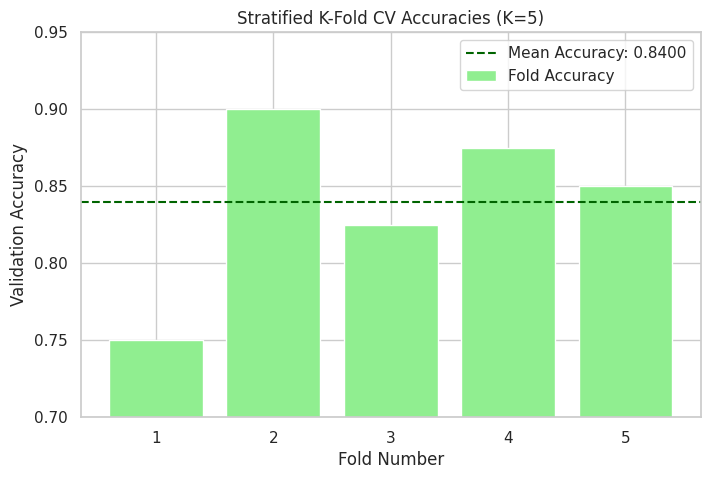

In [36]:
plt.figure(figsize=(8, 5))
plt.bar(range(1, N_SPLITS_STRATIFIED + 1), fold_accuracies_stratified, color='lightgreen', label='Fold Accuracy')
plt.axhline(mean_accuracy_stratified, color='darkgreen', linestyle='--', label=f'Mean Accuracy: {mean_accuracy_stratified:.4f}')
plt.xlabel("Fold Number")
plt.ylabel("Validation Accuracy")
plt.title(f"Stratified K-Fold CV Accuracies (K={N_SPLITS_STRATIFIED})")
plt.xticks(range(1, N_SPLITS_STRATIFIED + 1))
plt.ylim(min(fold_accuracies_stratified) - 0.05, max(fold_accuracies_stratified) + 0.05)
plt.legend()
plt.show()

In [37]:
print(f"\nComparison of Mean Accuracies:")
print(f"  K-Fold (standard):        {mean_accuracy_kfold:.4f} +/- {std_accuracy_kfold:.4f}")
print(f"  Stratified K-Fold:        {mean_accuracy_stratified:.4f} +/- {std_accuracy_stratified:.4f}")
print("Stratified K-Fold often gives a more reliable estimate, especially with class imbalance.")


Comparison of Mean Accuracies:
  K-Fold (standard):        0.8350 +/- 0.1158
  Stratified K-Fold:        0.8400 +/- 0.0515
Stratified K-Fold often gives a more reliable estimate, especially with class imbalance.


### Using Cross-Validation for Hyperparameter Tuning (Conceptual)
Cross-validation is essential for robust hyperparameter tuning. The general process:
1. Define a grid of hyperparameters to search (e.g., different learning rates,
   regularization strengths, polynomial degrees, kernel parameters for SVM).
2. For each combination of hyperparameters:
   
   1. Perform K-Fold (or Stratified K-Fold) cross-validation.
   2. Calculate the average validation performance (e.g., mean accuracy, mean F1-score)
      across the K folds for that hyperparameter combination.
3. Select the hyperparameter combination that yields the best average validation performance.
4. (Optional but recommended) Retrain your model on the *entire training dataset*
   using the best hyperparameters found.
5. Finally, evaluate this retrained model on a completely separate, held-out test set
   (that was not used at all during CV or hyperparameter tuning) to get a final
   estimate of its generalization performance.